In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind

detail data 
VendorID AcodeindicatingtheLPEPproviderthatprovided
 therecord.
 1=CreativeMobileTechnologies,LLC.
 2=VeriFoneInc.
 lpep_pickup_datetime Thedateandtimewhenthemeterwasengaged.
 lpep_dropoff_datetime Thedateandtimewhenthemeterwas
 disengaged.
 Passenger_count Thenumberofpassengersinthevehicle.
 Thisisadriver-enteredvalue.
 Trip_distance Theelapsedtripdistanceinmileswasreportedby
 thetaximeter.
 PULocationID TLCTaxiZoneinwhichthetaximeterwasengaged.
 DOLocationID TLCTaxiZoneinwhichthetaximeterwas
 disengaged.
 RateCodeID Thefinal ratecodeisineffectat theendof thetrip.
 1=Standardrate
 2=JFK
 3=Newark
 4=NassauorWestchester
 5=Negotiatedfare
 6=Groupride
 Store_and_fwd_flag Thisflagindicateswhetherthetriprecordwasheld
 inthevehiclememorybeforesendingtothevendor,
 aka“storeandforward,”becausethevehicledid
 nothaveaconnectiontotheserver.
 Y=storeandforwardtrip
 N=notastoreandforwardtrip
Payment_type Anumericcodesignifyinghowthepassengerpaid
 forthetrip.
 1=Creditcard
 2=Cash
 3=Nocharge
 4=Dispute
 5=Unknown
 6=Voidedtrip
 Fare_amount Thetime-and-distancefareiscalculatedbythe
 meter.ExtraMiscellaneousextrasandsurcharges.
 Currently, thisonlyincludesthe$0.50and$1rush
 hourandovernightcharges.
 MTA_tax $0.50MTAtaxthat isautomaticallytriggeredbased
 onthemeteredrateinuse.
 Improvement_surcharge $0.30improvementsurchargeassessedonhailed
 tripsat theflag
 drop.Theimprovementsurchargebeganbeing
 leviedin2015.
 Tip_amount Thisfieldisautomaticallypopulatedforcreditcard
 tips.Cashtipsarenot included.
 Tolls_amount Thetotalamountofall tollspaidinthetrip.
 Total_amount Thetotalamountchargedtopassengers.Doesnot
 includecashtips.
 Trip_type Acodeindicatingwhetherthetripwasastreethail
 oradispatchthat isautomaticallyassignedbased
 onthemeteredrateinusebutcanbealteredbythe
 driver.
 1=Street-hail
 2=Dispatch

---
# **Use case yang akan digunakan pada Data Taxi**
Pada latihan kali ini, kita akan menggunakan beberapa metode yang telah kita pelajari:

- Encoding
- Scaling
- Regularization
<br><br>

**Gunakan melb_data.csv (Melbourne House Data) dengan:**
- Features: 'Suburb', 'Rooms', 'Type', 'Method', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Regionname'
- Target: 'Price'

**Lakukan tahapan ini pada preprocessing dan modeling:**
- Lakukan EDA secara sederhana untuk eksplorasi dataset.
- Splitting dataset dengan proporsi 80:20 dan random_state = 2020
- Gunakan ColumnTransformer untuk encoding.
    - Ada 5 features categorical. Lakukan encoding pada features tersebut sesuai dengan karakter masing-masing feature.
- Lakukan Scaling pada numerical features. Pilih scaler yang menurut kamu paling sesuai berdasarkan karakteristik datanya.
- Lakukan fitting model dan evaluasi dengan metode Lasso pada data yang telah dilakukan preprocessing.
- Feature apa yang paling penting untuk menentukan harga rumah di Melbourne

Keterangan features:
https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot

In [9]:
df_raw= pd.read_csv('D:/PURWADHIKA/New York City Taxi and Limousine Trip Record/NYC TLC Trip Record.csv')
display(df_raw.head(),df_raw.tail())

C:\Users\tgs_e\AppData\Local\Temp\ipykernel_10828\3883687899.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw= pd.read_csv('D:/PURWADHIKA/New York City Taxi and Limousine Trip Record/NYC TLC Trip Record.csv')


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,NaN,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,NaN,1.0,16.70,NaN,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,NaN,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,NaN,1.0,5.41,NaN,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,NaN,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,NaN,1.0,21.04,NaN,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,NaN,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,NaN,1.0,19.18,NaN,NaN,NaN
68210,2,2023-01-31 23:51:00,2023-02-01 00:07:00,NaN,NaN,256,140,NaN,5.82,23.65,0.0,0.0,2.00,0.0,NaN,1.0,29.40,NaN,NaN,NaN


In [10]:
df = df_raw.copy()

In [11]:
print(f'Jumlah baris dan kolom di dataset df adalah {df.shape}')
df.info()

Jumlah baris dan kolom di dataset df adalah (68211, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14

In [12]:
display(df.describe(), df.describe(include='object'))

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,68211.000000,63887.000000,68211.000000,68211.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,0.0,68211.000000,68211.000000,63887.000000,63877.000000,63887.000000
mean,1.863028,1.117160,98.549735,138.429901,1.315870,8.114852,16.603545,0.825431,0.588340,2.139012,0.169627,NaN,0.951625,21.789377,1.373613,1.021933,0.726748
std,0.343820,1.372913,61.244314,76.761311,0.979054,585.105955,13.470121,1.269904,0.385819,3.052710,1.099789,NaN,0.196875,15.457115,0.508039,0.146465,1.212836
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,NaN,-1.000000,-71.500000,1.000000,1.000000,-2.750000
25%,2.000000,1.000000,74.000000,74.000000,1.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.900000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,75.000000,138.000000,1.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,17.900000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,129.000000,219.000000,1.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,NaN,1.000000,26.150000,2.000000,1.000000,2.750000
max,2.000000,99.000000,265.000000,265.000000,9.000000,120098.840000,490.000000,12.500000,2.750000,222.220000,36.050000,NaN,1.000000,491.000000,5.000000,2.000000,2.750000


,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag
count,68211,68211,63887
unique,66575,66519,2
top,2023-01-09 09:08:00,2023-01-09 00:00:00,N
freq,4,6,63579


In [13]:
df.isna().sum()/df.shape[0]*100

VendorID                   0.000000
lpep_pickup_datetime       0.000000
lpep_dropoff_datetime      0.000000
store_and_fwd_flag         6.339154
RatecodeID                 6.339154
PULocationID               0.000000
DOLocationID               0.000000
passenger_count            6.339154
trip_distance              0.000000
fare_amount                0.000000
extra                      0.000000
mta_tax                    0.000000
tip_amount                 0.000000
tolls_amount               0.000000
ehail_fee                100.000000
improvement_surcharge      0.000000
total_amount               0.000000
payment_type               6.339154
trip_type                  6.353814
congestion_surcharge       6.339154
dtype: float64

In [14]:
pd.set_option('display.max_colwidth', 1)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,VendorID,2,"[2, 1]"
1,lpep_pickup_datetime,66575,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 2023-01-01 00:35:12, 2023-01-01 00:13:14, 2023-01-01 00:33:04, 2023-01-01 00:53:31, 2023-01-01 00:09:14, 2023-01-01 00:11:58, 2023-01-01 00:41:29, 2023-01-01 00:50:32, 2023-01-01 00:16:12, 2023-01-01 00:08:43, 2023-01-01 00:26:32, 2023-01-01 00:18:35, 2023-01-01 00:39:32, 2023-01-01 00:49:34, 2023-01-01 00:10:45, 2023-01-01 00:35:11, 2023-01-01 00:31:06, 2023-01-01 00:14:37, 2023-01-01 00:26:21, 2023-01-01 00:41:56, 2023-01-01 00:32:02, 2023-01-01 00:55:13, 2023-01-01 00:01:31, 2023-01-01 00:22:31, 2023-01-01 00:57:28, 2023-01-01 00:35:21, 2023-01-01 00:52:52, 2023-01-01 00:32:56, 2023-01-01 00:24:01, 2023-01-01 00:46:48, 2023-01-01 00:40:58, 2023-01-01 00:20:23, 2023-01-01 01:49:24, 2023-01-01 00:41:53, 2023-01-01 00:56:26, 2023-01-01 00:33:10, 2023-01-01 00:58:28, 2023-01-01 00:42:49, 2023-01-01 00:48:21, 2023-01-01 00:08:05, 2023-01-01 00:13:47, 2023-01-01 00:16:10, 2023-01-01 00:04:25, 2023-01-01 00:33:38, 2023-01-01 00:46:08, 2023-01-01 01:00:08, 2023-01-01 00:28:04, 2023-01-01 00:23:04, 2023-01-01 00:34:07, 2023-01-01 00:52:03, 2023-01-01 00:25:31, 2023-01-01 00:53:09, 2023-01-01 00:42:37, 2023-01-01 00:39:52, 2023-01-01 00:15:32, 2023-01-01 00:06:48, 2023-01-01 00:57:15, 2023-01-01 00:14:13, 2023-01-01 00:52:48, 2023-01-01 00:34:13, 2023-01-01 00:44:41, 2023-01-01 00:11:12, 2023-01-01 01:44:43, 2023-01-01 01:04:44, 2023-01-01 01:48:11, 2023-01-01 01:11:39, 2023-01-01 01:54:25, 2023-01-01 01:59:10, 2023-01-01 01:22:35, 2023-01-01 01:37:10, 2023-01-01 01:46:22, 2023-01-01 01:59:48, 2023-01-01 01:09:49, 2023-01-01 01:23:35, 2023-01-01 01:53:20, 2023-01-01 01:32:14, 2023-01-01 01:01:05, 2023-01-01 01:34:41, 2023-01-01 01:52:08, 2023-01-01 01:49:28, 2023-01-01 01:03:59, 2023-01-01 01:13:11, 2023-01-01 01:40:06, 2023-01-01 01:33:50, 2023-01-01 01:45:19, 2023-01-01 01:51:29, 2023-01-01 01:34:07, 2023-01-01 01:10:08, 2023-01-01 01:32:17, 2023-01-01 01:48:28, 2023-01-01 01:30:43, 2023-01-01 01:51:10, 2023-01-01 01:09:36, 2023-01-01 01:19:54, 2023-01-01 01:31:10, 2023-01-01 01:42:30, 2023-01-01 00:57:51, 2023-01-01 01:27:36, ...]"
2,lpep_dropoff_datetime,66519,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 2023-01-01 00:41:32, 2023-01-01 00:19:03, 2023-01-01 00:39:02, 2023-01-01 01:11:04, 2023-01-01 00:26:39, 2023-01-01 00:24:55, 2023-01-01 00:46:26, 2023-01-01 01:13:42, 2023-01-01 00:41:43, 2023-01-01 00:17:08, 2023-01-01 00:45:31, 2023-01-01 00:30:09, 2023-01-01 01:18:06, 2023-01-01 01:08:23, 2023-01-01 00:19:37, 2023-01-01 01:17:35, 2023-01-01 00:42:23, 2023-01-01 00:21:50, 2023-01-01 00:30:26, 2023-01-01 00:46:06, 2023-01-01 00:41:25, 2023-01-01 00:59:47, 2023-01-01 00:16:02, 2023-01-01 00:39:24, 2023-01-01 01:09:31, 2023-01-01 00:53:49, 2023-01-01 01:00:53, 2023-01-01 00:42:53, 2023-01-01 00:32:05, 2023-01-01 01:08:17, 2023-01-01 01:04:32, 2023-01-01 00:24:32, 2023-01-01 01:57:51, 2023-01-01 00:41:58, 2023-01-01 01:14:41, 2023-01-01 00:43:08, 2023-01-01 01:14:46, 2023-01-01 00:51:53, 2023-01-01 01:23:50, 2023-01-01 00:13:26, 2023-01-01 00:25:57, 2023-01-01 00:54:55, 2023-01-01 00:17:50, 2023-01-01 00:38:51, 2023-01-01 00:59:10, 2023-01-01 01:05:46, 2023-01-01 00:43:45, 2023-01-01 23:18:32, 2023-01-01 00:50:01, 2023-01-01 00:57:56, 2023-01-01 00:38:40, 2023-01-01 01:13:35, 2023-01-01 00:47:15, 2023-01-01 00:48:54, 2023-01-01 00:23:03, 2023-01-01 01:08:47, 2023-01-01 01:00:15, 2023-01-01 00:25:43, 2023-01-01 01:21:19, 2023-01-01 00:43:57, 2023-01-01 00:48:26, 2023-01-01 00:38:12, 2023-01-01 01:57:31, 2023-01-01 01:11:23, 2023-01-01 02:05:51, 2023-01-01 01:41:21, 2023-01-01 02:05:19, 2023-01-01 02:11:36, 2023-01-01 01:25:11, 2023-01-01 01:41:30, 2023-01-01 02:04:14, 2023-01-01 02:05:29, 2023-01-01 01:17:55, 2023-01-01 01:53:43, 2023-01-01 02:27:01, 2023-01-01 01:43:55, 2023-01-01 01:13:02, 2023-01-01 02:00:06, 2023-01-01 02:00:57, 2023-01-01 02:13:18, 2023-01-01 01:07:17, 2023-01-01 01:26:01, 2

* Improvement_surcharge $0.30 improvement surcharge assessed on hailed trips at the flag drop.The improvement surcharge began being levied in 2015 - Berdasarkan definisi dari data tersebut improvement surcharge seharusnya merupakan nilai positif
* congestion_surcharge : juga seharusnya tidak memiliki nilai minus karena
* MTA_tax: 0.5 tax that is automatically trigerred based on metered rate in use. berdasarkan definisi data ini seharusnya tidak ada ada data minus pada datanya kemungkinan terjadi kesalahan data pada pencatatan datanya

untuk extra, MTA tax

In [15]:
# melakukan pengencekan duplikat
#improvement_surcharge,mta_tax	, extra	
duplicateRows = df[df.duplicated()]
print(duplicateRows)

Empty DataFrame
Columns: [VendorID, lpep_pickup_datetime, lpep_dropoff_datetime, store_and_fwd_flag, RatecodeID, PULocationID, DOLocationID, passenger_count, trip_distance, fare_amount, extra, mta_tax, tip_amount, tolls_amount, ehail_fee, improvement_surcharge, total_amount, payment_type, trip_type, congestion_surcharge]
Index: []


<Axes: >

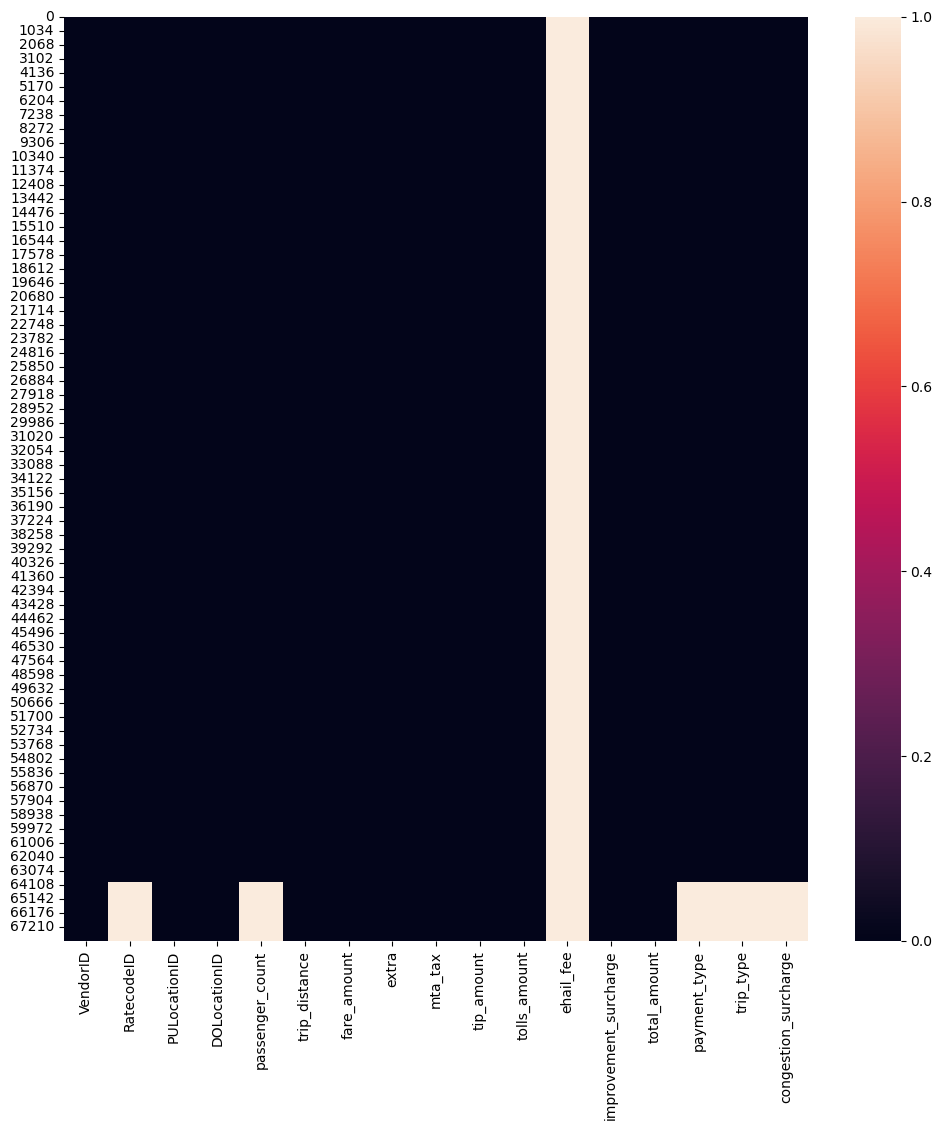

In [16]:
#melihat distribusi dari data kosong
plt.figure(figsize=(12,12))
sns.heatmap(df[['VendorID','RatecodeID','PULocationID','DOLocationID','passenger_count','trip_distance','fare_amount','extra','mta_tax','tip_amount','tolls_amount','ehail_fee','improvement_surcharge','total_amount','payment_type','trip_type','congestion_surcharge']].isna())

Strategi untuk handlemissing value dimana:store_and_fwd_flag =6,34%,, ratecode_ID:6,34%, passenger_count = 6.34% payment_type=6.339154


* asdada
trip_type                  6.353814
congestion_surcharge       6.339154

In [17]:
#karena ehail_fee 100% missing maka akan didrop ehail_fee                100.000000
df = df.drop(columns=['ehail_fee'])
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  improvement_surcharge  68211 non-null  float64
 15  to

In [18]:
#melakukan treatment pada data yang lain

In [40]:
df_drop = df.dropna(subset=['store_and_fwd_flag','RatecodeID','passenger_count', 'payment_type','trip_type'])

In [42]:
print(df_drop.info())

<class 'pandas.core.frame.DataFrame'>
Index: 63877 entries, 0 to 63886
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               63877 non-null  int64         
 1   lpep_pickup_datetime   63877 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  63877 non-null  datetime64[ns]
 3   store_and_fwd_flag     63877 non-null  object        
 4   RatecodeID             63877 non-null  float64       
 5   PULocationID           63877 non-null  int64         
 6   DOLocationID           63877 non-null  int64         
 7   passenger_count        63877 non-null  float64       
 8   trip_distance          63877 non-null  float64       
 9   fare_amount            63877 non-null  float64       
 10  extra                  63877 non-null  float64       
 11  mta_tax                63877 non-null  float64       
 12  tip_amount             63877 non-null  float64       
 13  tolls_

In [52]:
df_drop.isna().sum()/df_drop.shape[0]*100

VendorID                 0.0
lpep_pickup_datetime     0.0
lpep_dropoff_datetime    0.0
store_and_fwd_flag       0.0
RatecodeID               0.0
PULocationID             0.0
DOLocationID             0.0
passenger_count          0.0
trip_distance            0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
payment_type             0.0
trip_type                0.0
congestion_surcharge     0.0
pickup_hour              0.0
pickup_day               0.0
pickup_month             0.0
is_weekend               0.0
dtype: float64

In [43]:
display(df_drop.describe(), df_drop.describe(include='object'))

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,...,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,pickup_hour,pickup_day,pickup_month,is_weekend
count,63877.000000,63877,63877,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000,...,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000,63877.000000
mean,1.855895,2023-01-16 20:29:28.932651776,2023-01-16 20:47:27.346791168,1.101836,97.730200,138.308797,1.315920,2.576974,16.074491,0.880473,...,0.144182,0.949187,21.200955,1.373671,1.021933,0.726862,13.906555,2.842071,1.000360,0.246474
min,1.000000,2009-01-01 20:21:27,2009-01-02 11:07:31,1.000000,1.000000,1.000000,0.000000,0.000000,-70.000000,-2.500000,...,0.000000,-1.000000,-71.500000,1.000000,1.000000,-2.750000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,2023-01-09 12:15:18,2023-01-09 12:33:17,1.000000,74.000000,74.000000,1.000000,1.100000,9.000000,0.000000,...,0.000000,1.000000,12.600000,1.000000,1.000000,0.000000,10.000000,1.000000,1.000000,0.000000
50%,2.000000,2023-01-17 08:44:46,2023-01-17 08:59:19,1.000000,75.000000,138.000000,1.000000,1.800000,12.800000,0.000000,...,0.000000,1.000000,17.500000,1.000000,1.000000,0.000000,15.000000,3.000000,1.000000,0.000000
75%,2.000000,2023-01-24 16:18:41,2023-01-24 16:36:36,1.000000,117.000000,220.000000,1.000000,3.050000,19.100000,1.000000,...,0.000000,1.000000,25.500000,2.000000,1.000000,2.750000,18.000000,4.000000,1.000000,0.000000
max,2.000000,2023-02-01 03:10:05,2023-02-01 17:27:05,5.000000,265.000000,265.000000,9.000000,1571.970000,490.000000,12.500000,...,36.050000,1.000000,491.000000,5.000000,2.000000,2.750000,23.000000,6.000000,12.000000,1.000000
std,0.351199,NaN,NaN,0.620487,60.173501,76.883640,0.979123,6.760261,13.277144,1.292861,...,1.012740,0.201782,15.131310,0.508058,0.146465,1.212897,5.199829,1.960953,0.061678,0.430961


,store_and_fwd_flag
count,63877
unique,2
top,N
freq,63569


In [ ]:
#melakukan treatment terhadap nilai minus

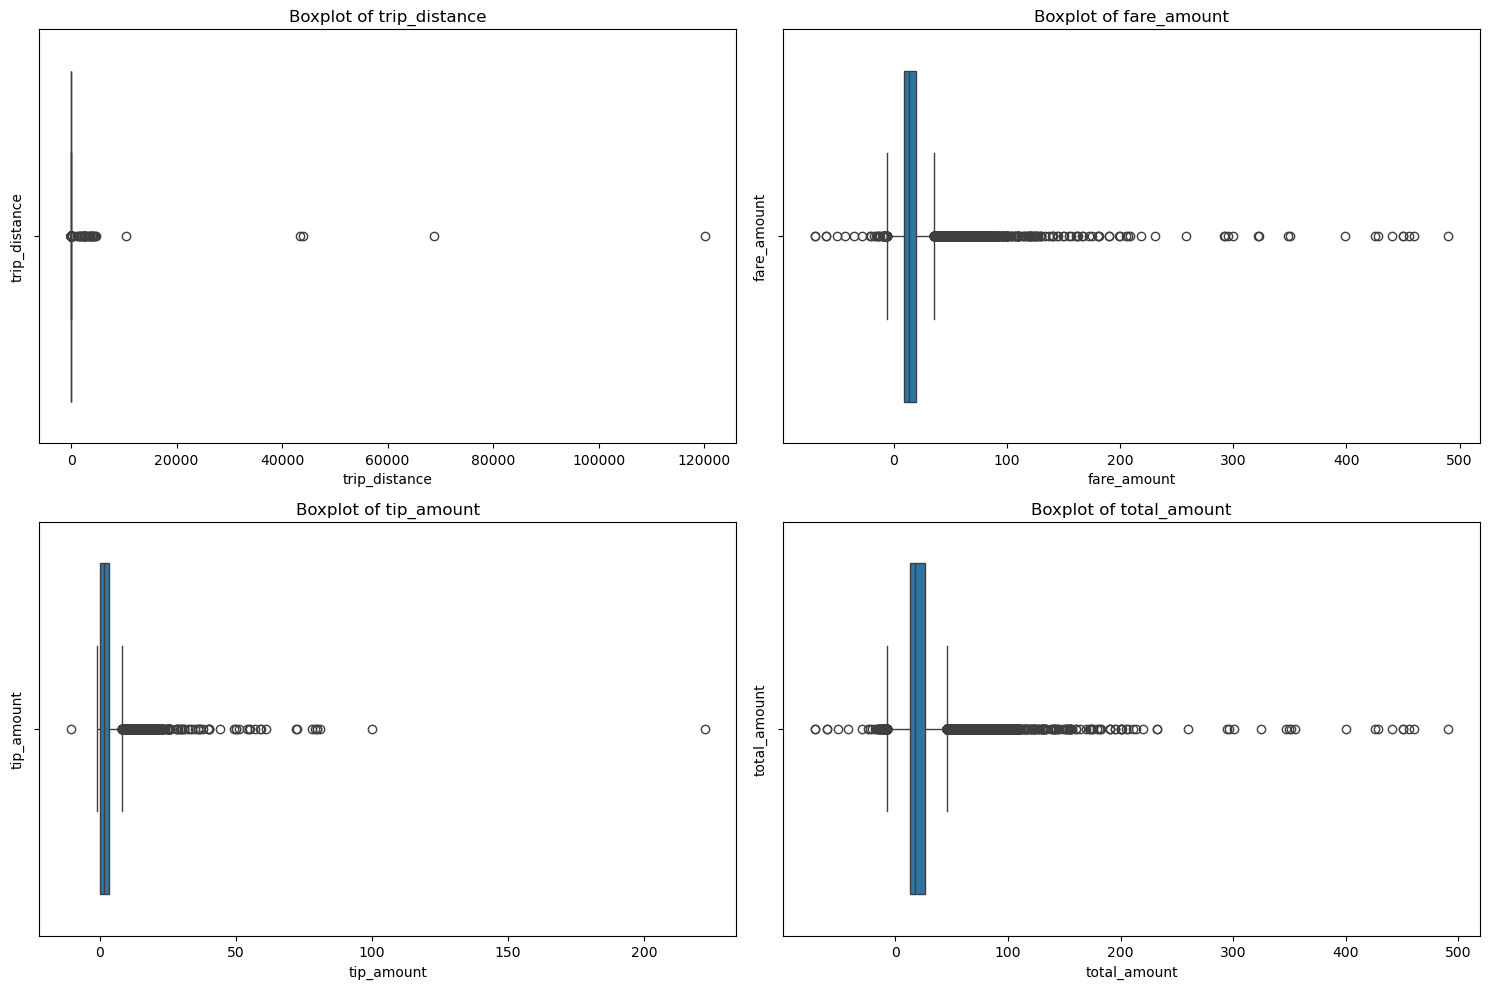

In [31]:

# melakukan pembuatan boxplot untuk mengetahui outliers, distribution
variables = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']

# Set up figure size and plot layout
plt.figure(figsize=(15, 10))

# Loop through variables to create subplots
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)  # Create 2x2 grid of plots
    sns.boxplot(data=df, x=var)
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

In [ ]:
#me;alilam

In [35]:

df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])



In [36]:
# melakukan pemisahan pickup
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour         # Extract hour
df['pickup_day'] = df['lpep_pickup_datetime'].dt.dayofweek      # 0 = Monday, 6 = Sunday
df['pickup_month'] = df['lpep_pickup_datetime'].dt.month        # Extract month
df['is_weekend'] = df['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend indicator

In [24]:
print(df[['pickup_hour', 'pickup_day', 'pickup_month', 'is_weekend']].head())

   pickup_hour  pickup_day  pickup_month  is_weekend
0  0            6           1             1         
1  0            6           1             1         
2  0            6           1             1         
3  0            6           1             1         
4  0            6           1             1         


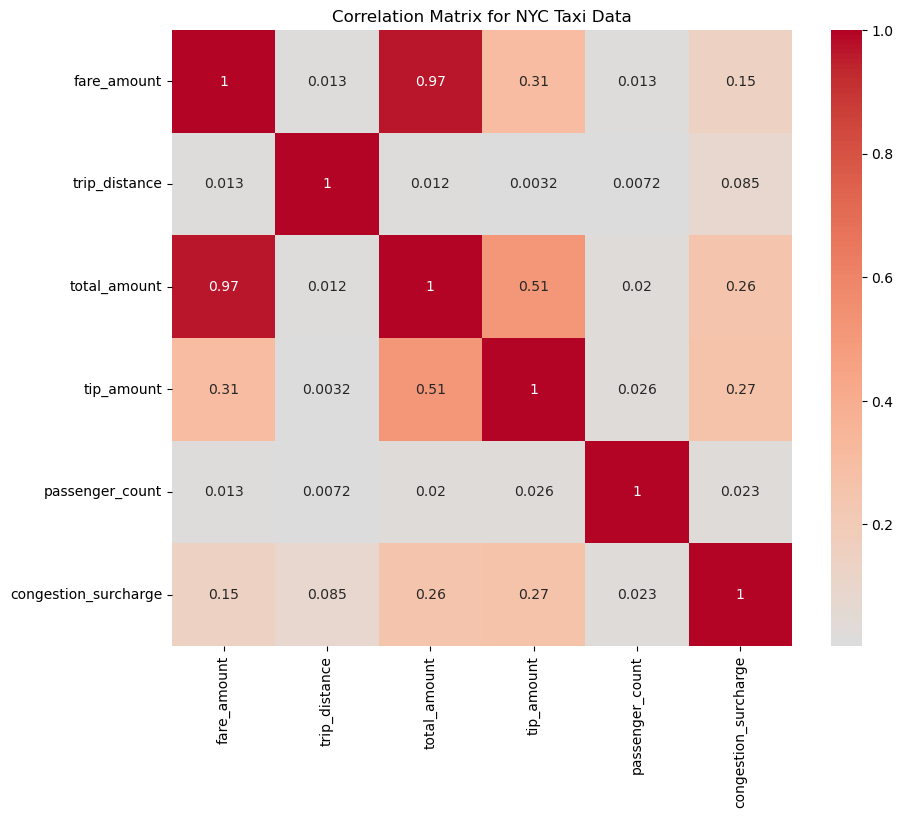

In [25]:
# Select relevant numerical columns for correlation analysis
numerical_cols = ['fare_amount', 'trip_distance', 'total_amount', 'tip_amount', 'passenger_count', 'congestion_surcharge']

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for NYC Taxi Data')
plt.show()

C:\Users\tgs_e\AppData\Local\Temp\ipykernel_10828\2027013295.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='pickup_hour', palette='Blues')


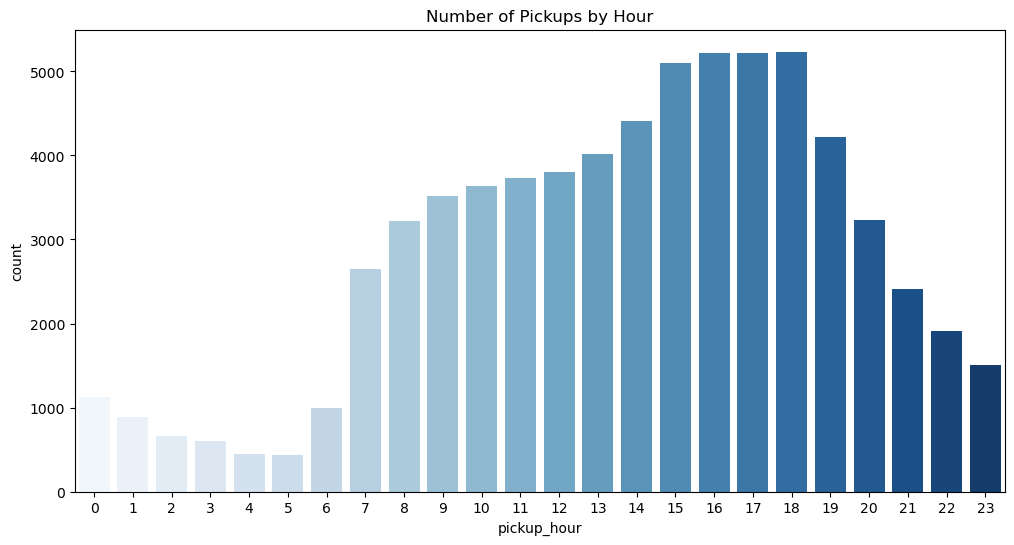

C:\Users\tgs_e\AppData\Local\Temp\ipykernel_10828\2027013295.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='pickup_day', palette='Greens')


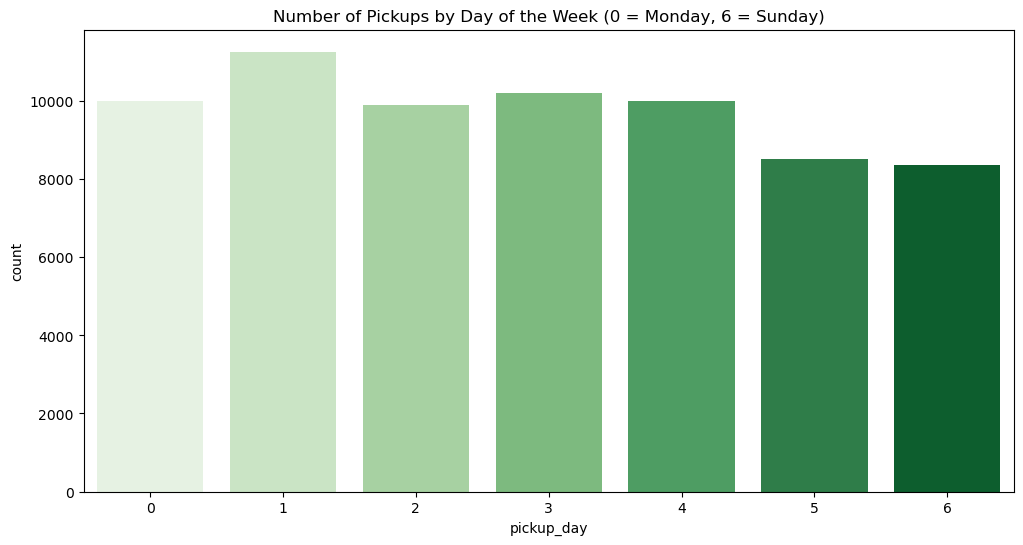

C:\Users\tgs_e\AppData\Local\Temp\ipykernel_10828\2027013295.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='pickup_month', palette='Purples')


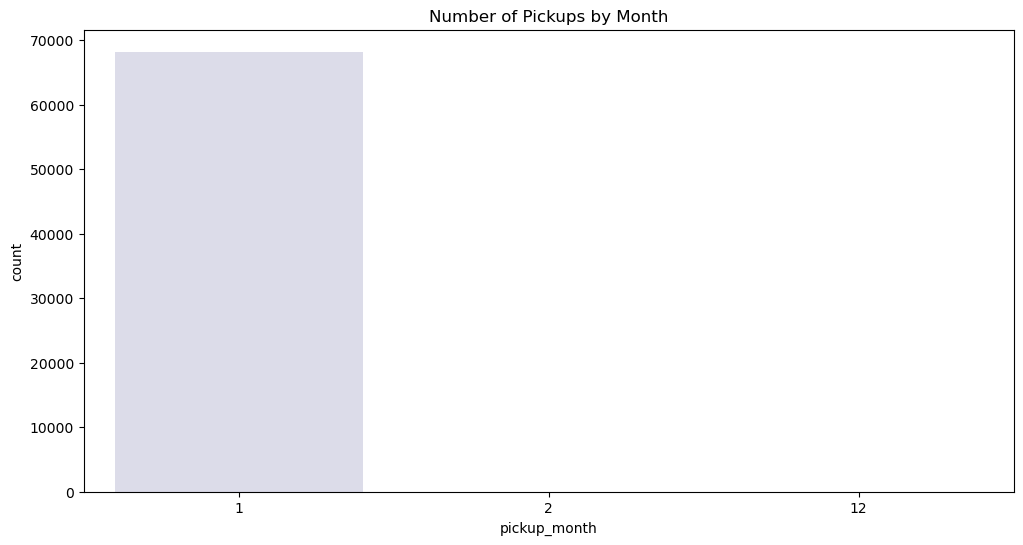

In [33]:
# Plot pickup hour distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='pickup_hour', palette='Blues')
plt.title('Number of Pickups by Hour')
plt.show()

# Plot pickup day distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='pickup_day', palette='Greens')
plt.title('Number of Pickups by Day of the Week (0 = Monday, 6 = Sunday)')
plt.show()

# Monthly pickup trend
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='pickup_month', palette='Purples')
plt.title('Number of Pickups by Month')
plt.show()

C:\Users\tgs_e\AppData\Local\Temp\ipykernel_10828\3186807580.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pickups.index, y=top_pickups.values, palette='Reds')


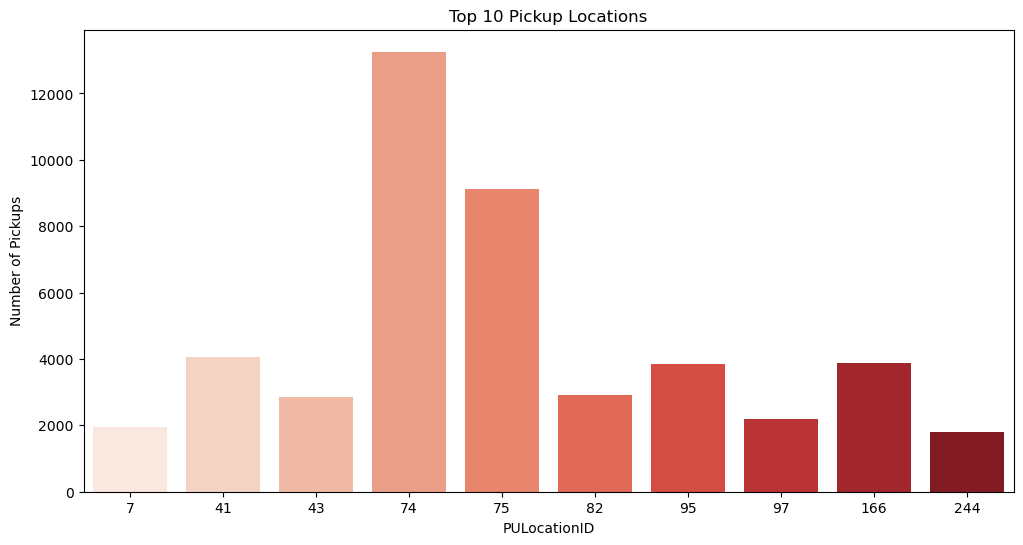

C:\Users\tgs_e\AppData\Local\Temp\ipykernel_10828\3186807580.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_dropoffs.index, y=top_dropoffs.values, palette='Blues')


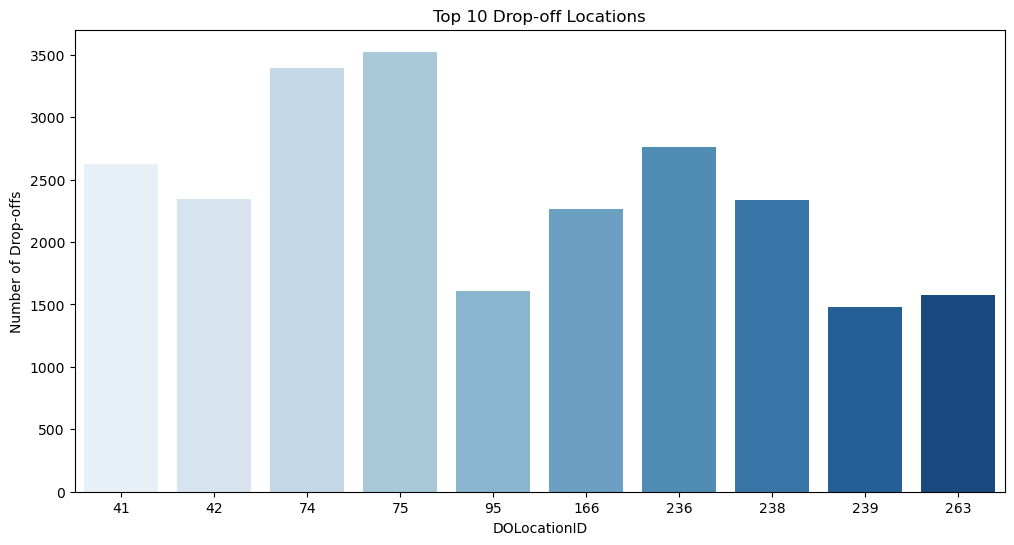

In [27]:
# Top 10 pickup locations
top_pickups = df['PULocationID'].value_counts().head(10)
top_dropoffs = df['DOLocationID'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_pickups.index, y=top_pickups.values, palette='Reds')
plt.title('Top 10 Pickup Locations')
plt.xlabel('PULocationID')
plt.ylabel('Number of Pickups')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_dropoffs.index, y=top_dropoffs.values, palette='Blues')
plt.title('Top 10 Drop-off Locations')
plt.xlabel('DOLocationID')
plt.ylabel('Number of Drop-offs')
plt.show()


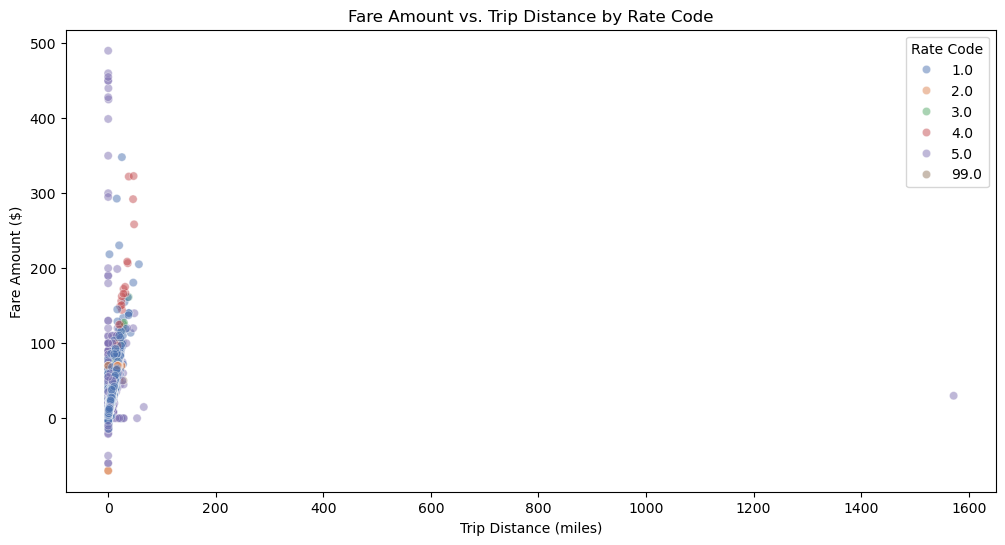

In [28]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='trip_distance', y='fare_amount', hue='RatecodeID', palette='deep', alpha=0.5)
plt.title('Fare Amount vs. Trip Distance by Rate Code')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.legend(title='Rate Code')
plt.show()

C:\Users\tgs_e\AppData\Local\Temp\ipykernel_10828\2477333983.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trip_pairs, x='Route', y='Trip_Count', palette='viridis')


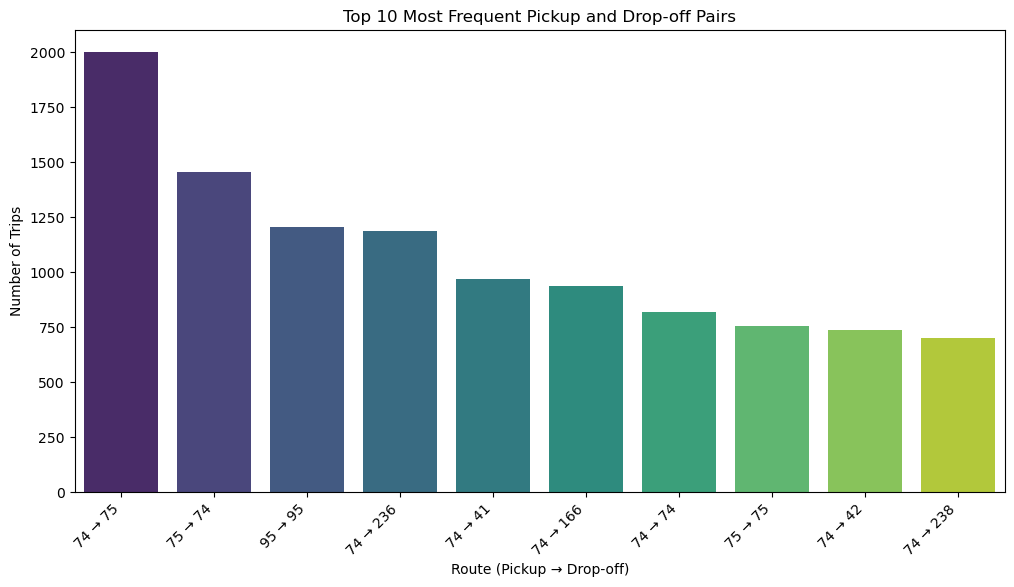

In [45]:


trip_pairs = (
    df.groupby(['PULocationID', 'DOLocationID'])
    .size()
    .reset_index(name='Trip_Count')
    .sort_values(by='Trip_Count', ascending=False)
    .head(10)
)

# Create a new column for route names
trip_pairs['Route'] = trip_pairs['PULocationID'].astype(str) + ' → ' + trip_pairs['DOLocationID'].astype(str)

# Plott
plt.figure(figsize=(12, 6))
sns.barplot(data=trip_pairs, x='Route', y='Trip_Count', palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Top 10 Most Frequent Pickup and Drop-off Pairs')
plt.xlabel('Route (Pickup → Drop-off)')
plt.ylabel('Number of Trips')
plt.show()


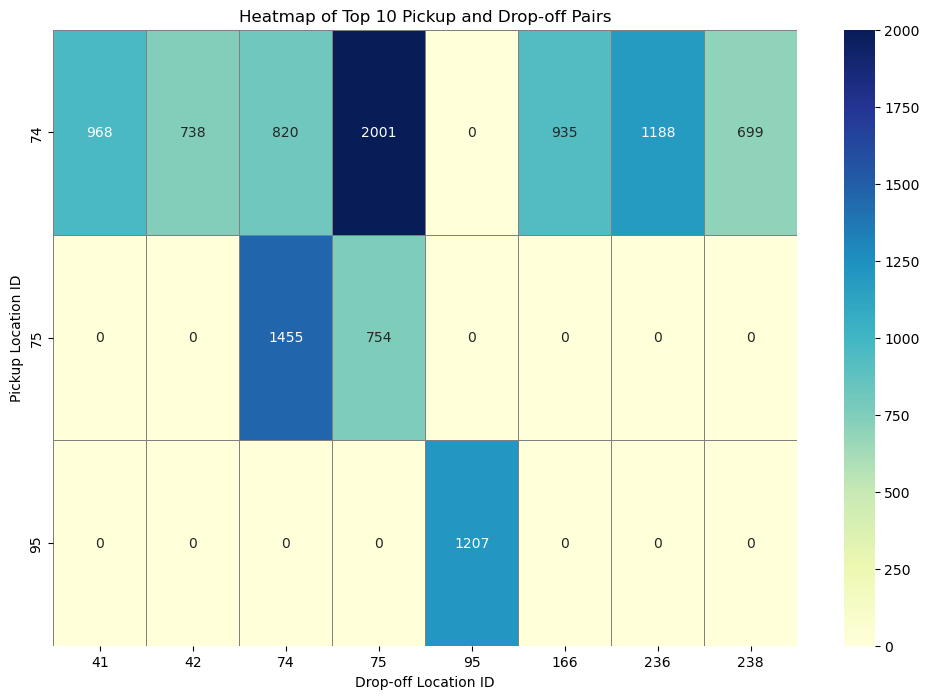

In [47]:
pivot_table = trip_pairs.pivot_table(
    index='PULocationID', 
    columns='DOLocationID', 
    values='Trip_Count', 
    fill_value=0
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5, linecolor='gray')
plt.title('Heatmap of Top 10 Pickup and Drop-off Pairs')
plt.xlabel('Drop-off Location ID')
plt.ylabel('Pickup Location ID')
plt.show()

In [48]:
# Calculate trip duration in minutes
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

# Group by pickup and dropoff zones and calculate average trip duration
longest_trip_zones = (
    df.groupby(['PULocationID', 'DOLocationID'])['trip_duration']
    .mean()
    .reset_index()
    .sort_values(by='trip_duration', ascending=False)
    .head(10)  # Show top 10 longest trip pairs
)

print("Top 10 Pickup and Drop-off Zones with Longest Trip Duration:")
print(longest_trip_zones)

Top 10 Pickup and Drop-off Zones with Longest Trip Duration:
      PULocationID  DOLocationID  trip_duration
711   36            137           1423.216667  
4054  167           60            1386.766667  
3094  116           161           1368.483333  
4256  179           114           1357.116667  
246   17            256           1282.833333  
766   37            137           1265.400000  
3277  129           16            1246.166667  
1641  65            178           886.066667   
2732  95            86            800.866667   
812   40            40            718.716667   


In [50]:
# Cari jumlah penumpang yang tidak masuk akal
unusual_passenger_count = df[(df['passenger_count'] <= 0) | (df['passenger_count'] > 6)]

print("\nPerjalanan dengan jumlah penumpang tidak wajar:")
print(unusual_passenger_count[['PULocationID', 'DOLocationID', 'passenger_count']])


Perjalanan dengan jumlah penumpang tidak wajar:
       PULocationID  DOLocationID  passenger_count
99     168           168           0.0            
254    129           129           0.0            
446    260           260           0.0            
486    42            127           0.0            
487    75            236           0.0            
...    ..            ...           ...            
63239  145           145           0.0            
63247  236           236           0.0            
63288  260           260           0.0            
63420  145           145           0.0            
63421  145           145           0.0            

[344 rows x 3 columns]


In [49]:
# Perjalanan dengan pickup dan drop-off di lokasi yang sama, tapi tarif tinggi
unusual_zone = df[(df['PULocationID'] == df['DOLocationID']) & (df['fare_amount'] > 50)]

print("\nPerjalanan dengan pickup dan drop-off di zona sama tapi tarif tinggi:")
print(unusual_zone[['PULocationID', 'DOLocationID', 'fare_amount', 'trip_duration']])


Perjalanan dengan pickup dan drop-off di zona sama tapi tarif tinggi:
       PULocationID  DOLocationID  fare_amount  trip_duration
104    179           179           190.00       0.083333     
163    36            36            100.00       0.050000     
185    223           223           110.00       1.766667     
198    101           101           90.00        0.500000     
199    101           101           60.00        0.400000     
...    ...           ...             ...             ...     
63131  55            55            85.60        98.850000    
63838  95            95            55.00        0.183333     
65122  193           193           50.26        4.000000     
66040  55            55            80.04        2.000000     
66609  132           132           78.25        1.000000     

[170 rows x 4 columns]


In [51]:
# Perjalanan dengan tarif nol atau negatif
unusual_fare = df[df['fare_amount'] <= 0]

print("\nPerjalanan dengan tarif nol atau negatif:")
print(unusual_fare[['PULocationID', 'DOLocationID', 'fare_amount', 'trip_distance']])

# Perjalanan dengan tarif sangat tinggi tetapi jarak pendek
unreasonable_fare = df[(df['fare_amount'] > 200) & (df['trip_distance'] < 5)]

print("\nPerjalanan dengan tarif sangat tinggi dan jarak pendek:")
print(unreasonable_fare[['PULocationID', 'DOLocationID', 'fare_amount', 'trip_distance']])



Perjalanan dengan tarif nol atau negatif:
       PULocationID  DOLocationID  fare_amount  trip_distance
662    75            74           -3.00         0.17         
898    193           193          -3.00         0.00         
1317   129           82           -8.60         0.64         
1581   264           264           0.00         0.00         
1686   75            75           -4.50         0.77         
...    ..            ..             ...          ...         
64376  25            25           -27.96        0.13         
64487  116           151          -43.54        2.22         
65108  168           159          -17.38        3.45         
66459  166           166          -35.01        0.38         
67461  248           126          -15.53        1.51         

[259 rows x 4 columns]

Perjalanan dengan tarif sangat tinggi dan jarak pendek:
       PULocationID  DOLocationID  fare_amount  trip_distance
2014   223           223           218.6        2.35         
7906   9

In [54]:
#melakukan payment analysis

payment_analysis = (
    df.groupby('payment_type')
    .agg(
        total_income=('total_amount', 'sum'),  # Total income from each payment type
        avg_income_per_trip=('total_amount', 'mean'),  # Average income per trip
        total_tip=('tip_amount', 'sum'),  # Total tips
        avg_tip_per_trip=('tip_amount', 'mean'),  # Average tip per trip
        trip_count=('payment_type', 'size')  # Total number of trips
    )
    .reset_index()
    .sort_values(by='trip_count', ascending=False)  # Sort by trip count
)

# Map payment_type codes to meaningful names
payment_type_mapping = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}
payment_analysis['payment_type'] = payment_analysis['payment_type'].map(payment_type_mapping)

print("Payment Method Analysis:")
print(payment_analysis)

Payment Method Analysis:
  payment_type  total_income  avg_income_per_trip  total_tip  \
0  Credit Card  936029.08     23.006171            130400.36   
1  Cash         415877.50     18.375641            5.00        
2  No Charge    2176.00       4.610169             0.00        
3  Dispute      408.95        4.304737             0.00        
4  Unknown      29.50         14.750000            0.00        

   avg_tip_per_trip  trip_count  
0  3.205043          40686       
1  0.000221          22632       
2  0.000000          472         
3  0.000000          95          
4  0.000000          2           


In [53]:
#Melakukan kalulasi trip dalam menit
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

# Group by VendorID and calculate key metrics
vendor_performance = (
    df.groupby('VendorID')
    .agg(
        avg_trip_duration=('trip_duration', 'mean'),
        avg_trip_distance=('trip_distance', 'mean'),
        total_trips=('VendorID', 'size'),
        avg_fare_amount=('fare_amount', 'mean'),
        avg_tip_amount=('tip_amount', 'mean')
    )
    .reset_index()
)

print("Vendor Performance Comparison:")
print(vendor_performance)

Vendor Performance Comparison:
   VendorID  avg_trip_duration  avg_trip_distance  total_trips  \
0  1         15.589420          2.236733           9343          
1  2         18.495294          9.047774           58868         

   avg_fare_amount  avg_tip_amount  
0  16.376213        1.665342        
1  16.639626        2.214189        
